<a href="https://colab.research.google.com/github/smobilia/melanoma-classifier/blob/master/Melanoma_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Import Necessary Python Packages**

In [1]:
import tensorflow as tf

from pathlib import Path
import pandas as pd
import numpy as np
import random
import os
from PIL import Image
import warnings

import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar

import IPython.display as display

# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Section 2: Download and Examine Data**
The following section downloads the scaled down Melanonma dataset from here:
https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164092

This baseline dataset was of the 256 X 256 images.

In [3]:
# Check for space in COLAB
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   34G   41G  46% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [4]:
# Use wget to upload parts of the data from Kaggle instead of the complete set (data limits)
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/756214%2F1339680%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1598898360&Signature=OzI%2FWZXB%2Bm29Um5KR9aTRcUOCXY6nyPILrOyQrM6foUAeXNXSf3jdweA4hVw8qXXVEfdvwZRS6xjUiK7NoGyhK9AFd8j%2B72rCUDwSCmyGTaDMZOSMu138cDfH8MA0NF62xhHzPvGy7pQBb0NyWq7KZx80NAhZ716l7ihRY2hVev6JjyL2cvGcCF76B7yidG3pi9sZBB58PmHaVj6KonGpA0AYGLEQvNJu02f1drhb%2BlcN%2FyKbrGZUe3WHOMSLl3iFS%2FiBppoKBgeC%2BEqAYk6fMRhmtJ4%2B00ed2grYgswPPUB2CN8t5IJaK3HlNKVKydtFNWqyoqDor6K2iMpTgCsTw%3D%3D" -c -O '756214_1339680_bundle_archive.zip'

--2020-08-28 18:39:05--  https://storage.googleapis.com/kaggle-data-sets/756214%2F1339680%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1598898360&Signature=OzI%2FWZXB%2Bm29Um5KR9aTRcUOCXY6nyPILrOyQrM6foUAeXNXSf3jdweA4hVw8qXXVEfdvwZRS6xjUiK7NoGyhK9AFd8j%2B72rCUDwSCmyGTaDMZOSMu138cDfH8MA0NF62xhHzPvGy7pQBb0NyWq7KZx80NAhZ716l7ihRY2hVev6JjyL2cvGcCF76B7yidG3pi9sZBB58PmHaVj6KonGpA0AYGLEQvNJu02f1drhb%2BlcN%2FyKbrGZUe3WHOMSLl3iFS%2FiBppoKBgeC%2BEqAYk6fMRhmtJ4%2B00ed2grYgswPPUB2CN8t5IJaK3HlNKVKydtFNWqyoqDor6K2iMpTgCsTw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 829854214 (791M) [application/zip]
Saving to: ‘756214_1339680_bundle_archive.zip’

756214_1339680_bund 100%[===================>] 791.41M   124MB/s    in 5.9

In [5]:
!ls

756214_1339680_bundle_archive.zip


In [6]:
!unzip 756214_1339680_bundle_archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/ISIC_8513112.jpg  
  inflating: train/ISIC_8513649.jpg  
  inflating: train/ISIC_8514170.jpg  
  inflating: train/ISIC_8514989.jpg  
  inflating: train/ISIC_8515165.jpg  
  inflating: train/ISIC_8515281.jpg  
  inflating: train/ISIC_8515582.jpg  
  inflating: train/ISIC_8515674.jpg  
  inflating: train/ISIC_8516181.jpg  
  inflating: train/ISIC_8516223.jpg  
  inflating: train/ISIC_8516516.jpg  
  inflating: train/ISIC_8516631.jpg  
  inflating: train/ISIC_8516659.jpg  
  inflating: train/ISIC_8516922.jpg  
  inflating: train/ISIC_8517305.jpg  
  inflating: train/ISIC_8517492.jpg  
  inflating: train/ISIC_8518406.jpg  
  inflating: train/ISIC_8519222.jpg  
  inflating: train/ISIC_8519402.jpg  
  inflating: train/ISIC_8519725.jpg  
  inflating: train/ISIC_8519890.jpg  
  inflating: train/ISIC_8519931.jpg  
  inflating: train/ISIC_8520545.jpg  
  inflating: train/ISIC_8521162.jpg  
  inflating: train/ISIC_8521337.jpg  

In [7]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   33G  51% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   35G   40G  47% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


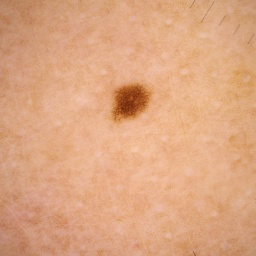

In [8]:
Image.open('train/ISIC_9246022.jpg')

In [9]:
meta_data_df = pd.read_csv("train.csv")
meta_data_df.head(40)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0,1,6000,4000
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0,14,5184,3456
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0,11,2592,1936
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0,0,6000,4000
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0,9,6000,4000


In [10]:
meta_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [11]:
meta_data_df["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [12]:
meta_data_df["benign_malignant"].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

# **Section 3: Split and Transform Data**
This section splits the data into the training and validation sets and trasforms the data for the neural network.

In [13]:
# Splits Training Data into Training Data and 
      # Validation Data (80% Training/20% Validation)
def get_train_val_split(df):
    """
    Takes a dataframe input, splits the data into training and validation data and removes duplicate entries
    """
    #Remove Duplicates
    df = df[df.tfrecord != -1].reset_index(drop=True)
    #We are splitting data based on triple stratified kernel provided here 
    #https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
    train_tf_records = list(range(len(df.tfrecord.unique())))
    random.shuffle(train_tf_records)
    train_tf_records = train_tf_records[:12]
    split_cond = df.tfrecord.apply(lambda x: x in train_tf_records)
    train_df = df[split_cond].reset_index()
    valid_df = df[~split_cond].reset_index()
    return train_df,valid_df

In [14]:
melanoma_train_df, melanoma_valid_df = get_train_val_split(meta_data_df)

In [15]:
melanoma_valid_df["target"].value_counts()

0    6426
1     115
Name: target, dtype: int64

In [16]:
# Creates Transform Pipeline
transform_pipeline = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# **Section 4: Format Data**

In [17]:
class MelanomaDataset(Dataset):
  """
  Converts the Datasets for the Melanoma Classifier into appropriate PyTorch Tensors. 
  Based on this tutorial:
  http://seba1511.net/tutorials/beginner/data_loading_tutorial.html
  """
  def __init__(self, df, im_path, transforms=None):
    """
    Args:
        dataframe (pandas df): Dataframe from CSV file.
        im_path (string): Directory with image files.
        transforms (callable, optional): Optional transforms to be applied to the images.
        metadata (callable, optional): Optional metadata to be used in the classifier.
    """
    self.df = df
    self.im_path = im_path
    self.transforms = transforms

  def __getitem__(self,idx):
    """
    Makes df[idx] return the idxth sample
    """
    img_path = f"{self.im_path}/{self.df.iloc[idx]['image_name']}.jpg"
    img = Image.open(img_path)
    if self.transforms:
      img = self.transforms(img)
    if "target" in self.df.columns:
      label = self.df.iloc[idx]['target']
      return img, torch.tensor([label],dtype=torch.float32)
    else:
      return img

  def __len__(self):
    """
    Makes the len function return the size of the dataset
    """
    return self.df.shape[0]

# **Section 5: Create CNN**
Trains the images on the VGG16 Network.

In [18]:
class MelanomaVGG16BNNet(nn.Module):
  """
  Defines the Melanoma Network using the VGG16 BN Net
  """
  def __init__(self):
    super(MelanomaVGG16BNNet, self).__init__()
    # input image is 224 X 224
    self.vgg16Net = models.vgg16_bn(pretrained=True)
    self.fc1 = nn.Linear(1000, 1)

  def forward(self, x):
    """
    Max Pooling using a 2 X 2 kernel
    """
    x = self.vgg16Net(x)
    x = self.fc1(x)
    return x

# **Section 6: Helper Functions**
These helper fuctions assist in the training of the neural network.

In [19]:
def get_device():
  """
  Function checks to see if GPU is active
  """
  return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
def get_model(lr=1e-5, wd=0.01, opt_fn=torch.optim.AdamW, device=None):
  """
  Get the CNN model
  """
  device = device if device else get_device()
  model = MelanomaVGG16BNNet()
  opt = opt_fn(model.parameters(), lr=lr, weight_decay=wd)
  model = model.to(device)
  return model, opt

In [21]:
def training_step(xb,yb,model,loss_fn,opt,device, scheduler):
  """
  Feeds the trainging images into the CNN. 
  """
  xb,yb = xb.to(device), yb.to(device)
  out = model(xb)
  opt.zero_grad()
  loss = loss_fn(out,yb)
  loss.backward()
  opt.step()
  scheduler.step()
  return loss.item()

In [22]:
def validation_step(xb,yb,model,loss_fn,device):
  """
  Feeds the validation images through the network to get predicted values.
  """
  xb,yb = xb.to(device), yb.to(device)
  out = model(xb)
  loss = loss_fn(out,yb)
  out = torch.sigmoid(out)
  return loss.item(),out

In [23]:
def get_data(train_df,valid_df,train_tfms,test_tfms,bs):
  """
  Generates the training and validation datasets and loads them into the PyTorch Dataloader.
  """
  train_ds = MelanomaDataset(df=train_df,im_path='train/',transforms=train_tfms)
  valid_ds = MelanomaDataset(df=valid_df,im_path='train/',transforms=test_tfms)
  train_dl = DataLoader(dataset=train_ds,batch_size=bs,shuffle=True,num_workers=4)
  valid_dl = DataLoader(dataset=valid_ds,batch_size=bs*2,shuffle=False,num_workers=4)
  return train_dl,valid_dl

In [24]:
def fit(epochs,model,train_dl,valid_dl,opt,device=None,loss_fn=F.binary_cross_entropy_with_logits):
  """
  Fits the training data to the model and prints out the training and validation accuracy and ROC 
  """
  
  device = device if device else get_device()
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
  val_rocs = [] 
  
  #Creating progress bar
  mb = master_bar(range(epochs))
  mb.write(['epoch','train_loss','valid_loss','accuracy','val_roc'],table=True)
  
  for epoch in mb:    
    trn_loss,val_loss = 0.0,0.0
    val_preds = np.zeros((len(valid_dl.dataset),1))
    val_acc_preds = np.zeros((len(valid_dl.dataset),1))
    val_targs = np.zeros((len(valid_dl.dataset),1))
    
    #Training
    model.train()
    
    #For every batch 
    for xb,yb in progress_bar(train_dl,parent=mb):
      trn_loss += training_step(xb,yb,model,loss_fn,opt,device, scheduler) 
    trn_loss /= mb.child.total

    #Validation
    model.eval()
    with torch.no_grad():
      for i,(xb,yb) in enumerate(progress_bar(valid_dl,parent=mb)):
        loss,out = validation_step(xb,yb,model,loss_fn,device)
        val_loss += loss
        bs = xb.shape[0]
        out_acc = (out > 0.5).float() * 1
        val_preds[i*bs:i*bs+bs] = out.cpu().numpy()
        val_acc_preds[i*bs:i*bs+bs] = out_acc.cpu().numpy()
        val_targs[i*bs:i*bs+bs] = yb.cpu().numpy()

    val_loss /= mb.child.total
    val_acc = accuracy_score(val_targs.reshape(-1),val_acc_preds.reshape(-1))
    val_roc = roc_auc_score(val_targs.reshape(-1),val_preds.reshape(-1))
    val_rocs.append(val_roc)

    mb.write([f'Epoch: {epoch}',f'Training Loss: {trn_loss:.6f}',f' Validation Loss: {val_loss:.6f}',
              f'Validation Acc: {val_acc:.6f}', f'Validation ROC: {val_roc:.6f}'],table=True)
  
  return model, val_rocs, val_preds, val_targs

# **Section 7: Fit the Training Data to the Network**

In [25]:
BATCH_SIZE = 30

train_dl,valid_dl = get_data(melanoma_train_df,melanoma_valid_df,transform_pipeline,transform_pipeline,BATCH_SIZE)
model, opt = get_model(lr=1e-4, wd=1e-4)

In [26]:
model,val_rocs,val_preds,val_targs = fit(15,model,train_dl,valid_dl,opt)
torch.save(model.state_dict(),f'vgg16net.pth')

epoch,train_loss,valid_loss,accuracy,val_roc
Epoch: 0,Training Loss: 0.087953,Validation Loss: 0.089733,Validation Acc: 0.982419,Validation ROC: 0.820700
Epoch: 1,Training Loss: 0.085705,Validation Loss: 0.120429,Validation Acc: 0.982419,Validation ROC: 0.797940
Epoch: 2,Training Loss: 0.084912,Validation Loss: 0.072823,Validation Acc: 0.982419,Validation ROC: 0.863553
Epoch: 3,Training Loss: 0.075459,Validation Loss: 0.090167,Validation Acc: 0.982419,Validation ROC: 0.784242
Epoch: 4,Training Loss: 0.073346,Validation Loss: 0.079192,Validation Acc: 0.982419,Validation ROC: 0.871745
Epoch: 5,Training Loss: 0.071280,Validation Loss: 0.072571,Validation Acc: 0.982419,Validation ROC: 0.885509
Epoch: 6,Training Loss: 0.068522,Validation Loss: 0.071075,Validation Acc: 0.982419,Validation ROC: 0.892736
Epoch: 7,Training Loss: 0.065315,Validation Loss: 0.073132,Validation Acc: 0.982419,Validation ROC: 0.885725
Epoch: 8,Training Loss: 0.060249,Validation Loss: 0.070230,Validation Acc: 0.982419,Validation ROC: 0.895792
Epoch: 9,Training Loss: 0.050896,Validation Loss: 0.081681,Validation Acc: 0.978444,Validation ROC: 0.888858


In [27]:
# Looking at the Confusion Matrices we can get an idea of how the model changes based on the threshold for predicted Melanoma.

PRED_THRESHOLD_1 = 0.2
PRED_THRESHOLD_2 = 0.3
PRED_THRESHOLD_3 = 0.5
PRED_THRESHOLD_4 = 0.6
valid_target_preds_1 = (val_preds > PRED_THRESHOLD_1)
valid_target_preds_2 = (val_preds > PRED_THRESHOLD_2)
valid_target_preds_3 = (val_preds > PRED_THRESHOLD_3)
valid_target_preds_4 = (val_preds > PRED_THRESHOLD_4)
valid_cm_final_1 = confusion_matrix(val_targs.reshape(-1),valid_target_preds_1.reshape(-1))
valid_final_accuracy_1 = accuracy_score(val_targs.reshape(-1),valid_target_preds_1.reshape(-1))
valid_cm_final_2 = confusion_matrix(val_targs.reshape(-1),valid_target_preds_2.reshape(-1))
valid_final_accuracy_2 = accuracy_score(val_targs.reshape(-1),valid_target_preds_2.reshape(-1))
valid_cm_final_3 = confusion_matrix(val_targs.reshape(-1),valid_target_preds_3.reshape(-1))
valid_final_accuracy_3 = accuracy_score(val_targs.reshape(-1),valid_target_preds_3.reshape(-1))
valid_cm_final_4 = confusion_matrix(val_targs.reshape(-1),valid_target_preds_4.reshape(-1))
valid_final_accuracy_4 = accuracy_score(val_targs.reshape(-1),valid_target_preds_4.reshape(-1))

print('Threshold: 20%\nAccuracy:', valid_final_accuracy_1,'\nConfusion Matrix:\n',valid_cm_final_1)

print('Threshold: 30%\nAccuracy:', valid_final_accuracy_2,'\nConfusion Matrix:\n',valid_cm_final_2)

print('Threshold: 50%\nAccuracy:', valid_final_accuracy_3,'\nConfusion Matrix:\n',valid_cm_final_3)

print('Threshold: 60%\nAccuracy:', valid_final_accuracy_4,'\nConfusion Matrix:\n',valid_cm_final_4)


Threshold: 20%
Accuracy: 0.9761504357131937 
Confusion Matrix:
 [[6370   56]
 [ 100   15]]
Threshold: 30%
Accuracy: 0.9773734902920043 
Confusion Matrix:
 [[6380   46]
 [ 102   13]]
Threshold: 50%
Accuracy: 0.9790551903378688 
Confusion Matrix:
 [[6393   33]
 [ 104   11]]
Threshold: 60%
Accuracy: 0.9795138358049228 
Confusion Matrix:
 [[6398   28]
 [ 106    9]]


# **Section 8: Generating the Test Data Submission for Kaggle**

In [28]:
# Transforms and loads the test data into the data loader.
test_df = pd.read_csv("test.csv")

model.load_state_dict(torch.load(f'vgg16net.pth',map_location=device))

test_ds = MelanomaDataset(df=test_df,im_path='test/',transforms=transform_pipeline)
test_dl = DataLoader(dataset=test_ds,batch_size=BATCH_SIZE*2,shuffle=False,num_workers=4)

In [29]:
def get_preds(model,test_dl,device=None):
  """
  Passes the test images through the CNN to generate the submissions for Kaggle
  """
  if device is None:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  preds = np.zeros(len(test_ds))
  test_preds = []
  with torch.no_grad():
    for xb in progress_bar(test_dl):
      xb = xb.to(device)
      out = model(xb)
      out = torch.sigmoid(out)
      test_preds.extend(out.cpu().numpy())
    preds += np.array(test_preds).reshape(-1)
  return preds

preds = get_preds(model,test_dl) 

In [30]:
# Writes the predicted results into a CSV file for Kaggle submission.
subm = pd.read_csv('sample_submission.csv')
subm.target = preds
subm.to_csv('vgg16_submission.csv',index=False)

In [31]:
#Checks the results of the submission to Kaggle
test_subm = pd.read_csv('vgg16_submission.csv')
test_subm.head(40)

,image_name,target
0,ISIC_0052060,5.942361e-11
1,ISIC_0052349,2.090708e-23
2,ISIC_0058510,1.466037e-18
3,ISIC_0073313,1.041176e-25
4,ISIC_0073502,3.197690e-07
5,ISIC_0074618,2.399433e-15
6,ISIC_0076801,6.566102e-14
7,ISIC_0077586,1.032870e-11
8,ISIC_0082004,1.498637e-04
9,ISIC_0082785,4.565744e-11


In [32]:
test_subm["Cancerous"] = test_subm["target"]>0.3
test_subm["Cancerous"].value_counts()

False    10815
True       167
Name: Cancerous, dtype: int64